# Model visualization, gaussian noise

In [1]:
import os, scipy.io 
import numpy as np 
import matplotlib.pyplot as plt 

### load model

In [2]:
model_dir = '/Users/Renee/Downloads/spikeRNN/models/go-nogo/P_rec_0.2_Taus_4.0_20.0'
# model_fname = 'Task_go-nogo_N_200_Taus_4.0_20.0_Act_sigmoid_2024_09_13_112219_noise.mat'
# model_fname = 'Task_go-nogo_N_200_Taus_4.0_20.0_Act_sigmoid_2024_09_13_144639_noise_gaussian.mat'
model_fname = 'Task_go-nogo_N_200_Taus_4.0_20.0_Act_sigmoid_2024_09_13_154428_noise_pulse.mat'
mat_data = scipy.io.loadmat(os.path.join(model_dir, model_fname))

In [3]:
for keys in mat_data.keys():
    print(keys)

__header__
__version__
__globals__
x0
r0
w0
taus_gaus0
w_in0
w_noise0
u
o
w
x
target
w_out
r
m
som_m
N
C
noise_type
exc
inh
w_in
w_noise
b_out
som_N
losses
taus
eval_perf_mean
eval_loss_mean
eval_os
eval_labels
taus_gaus
tr
activation


In [4]:
w = mat_data['w']
print(w.shape)

(200, 200)


### Visualize outputs

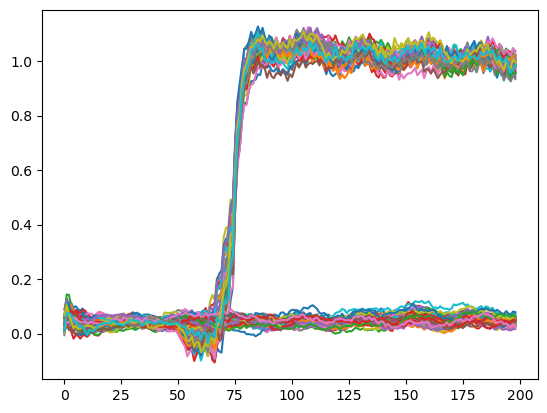

In [5]:
plt.figure()
plt.plot(np.transpose(mat_data['eval_os'][:,]))
plt.show()

### get final variables

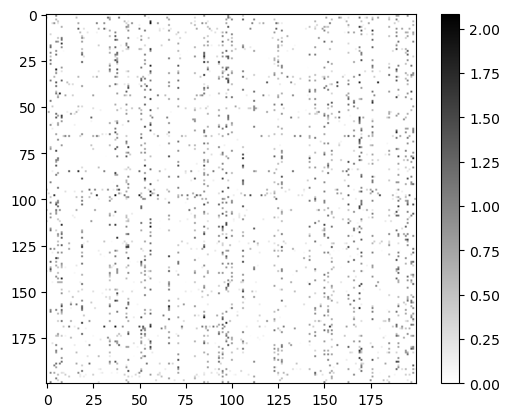

In [6]:
plt.imshow(w, cmap='binary')
plt.colorbar()

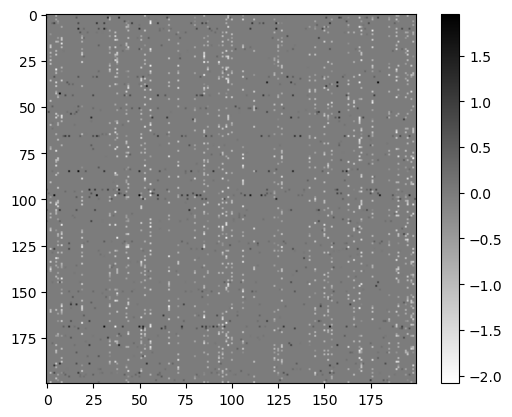

In [7]:
m = mat_data['m']
final_w = np.matmul(w, m)
plt.imshow(final_w, cmap='binary')
plt.colorbar()
plt.show()

In [8]:
taus_gaus = mat_data['taus_gaus']
taus = mat_data['taus'].flatten()
taus_sig = (1/(1+np.exp(-taus_gaus))*(taus[1] - taus[0])) + taus[0]
taus_sig.shape

(200, 1)

### model eval

In [9]:
from model import generate_input_stim_go_nogo

Instructions for updating:
non-resource variables are not supported in the long term


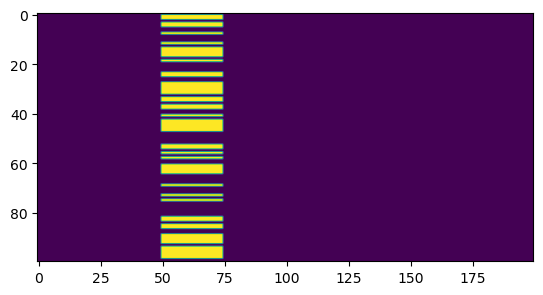

In [10]:
# GO-NoGo task
settings = {
    'T': 200, # trial duration (in steps)
    'stim_on': 50, # input stim onset (in steps) 
    'stim_dur': 25, # input stim duration (in steps) 
    'DeltaT': 1, # sampling rate
    'taus': 20, # decay time-constants (in steps) 
    'task': 'go-nogo', # task name
}
inputs = np.zeros((100, settings['T']))
for i in range(100):
    u, label = generate_input_stim_go_nogo(settings)
    inputs[i, :] = u
# Plotting the generated trials
plt.figure()
plt.imshow(inputs)
plt.show()

In [11]:
import importlib
import model 

(200, 200)
(200, 200)
(200,)
(200, 200)


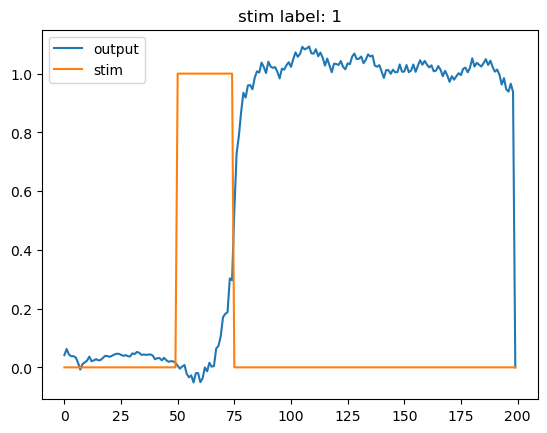

In [12]:
importlib.reload(model)
u, label = generate_input_stim_go_nogo(settings)
x, r, o, epsp = model.eval_tf(model_dir=f'{model_dir}/{model_fname}', settings=settings, u=u)
print(x.shape)
print(r.shape)
print(o.shape)
print(epsp.shape)

plt.figure()
plt.plot(o)
plt.plot(u.flatten())
plt.title(f'stim label: {label}')
plt.legend(['output','stim'])
plt.show()

In [13]:
# model eval on 100 random trials
importlib.reload(model)

n_trials = 100
resp_onset = settings['stim_on'] + settings['stim_dur']
eval_amp_threshold = 0.7
eval_perf = np.zeros(n_trials)

for i in range(n_trials):
    eval_u, eval_label = generate_input_stim_go_nogo(settings)
    _, _, eval_o, _ = model.eval_tf(model_dir=f'{model_dir}/{model_fname}', settings=settings, u=eval_u)
    if eval_label == 1:
        if np.max(eval_o[resp_onset:]) > eval_amp_threshold:
            eval_perf[i] = 1
    else:
        if np.max(np.abs(eval_o[resp_onset:])) < 0.3:
            eval_perf[i] = 1

eval_perf_mean = np.nanmean(eval_perf)
print("Performance: %.2f"%(eval_perf_mean))

Performance: 1.00


### plotting model firing rates r, and synaptic current x

In [14]:
r = mat_data['r']
x = mat_data['x']
print(r.shape)
print(x.shape)

(200, 200, 1)
(200, 200, 1)


In [15]:
exc = mat_data['exc']
exc_ind = np.where(exc == 1)[0]
inh = mat_data['inh']
inh_ind = np.where(inh == 1)[0]
print(inh_ind)

[  2   5   6   8  19  34  37  38  43  44  51  53  56  66  71  80  85  87
  93  95  97  98 100 106 112 123 125 127 142 145 150 152 154 163 166 169
 170 176 185 189 190 194 195 197 198]


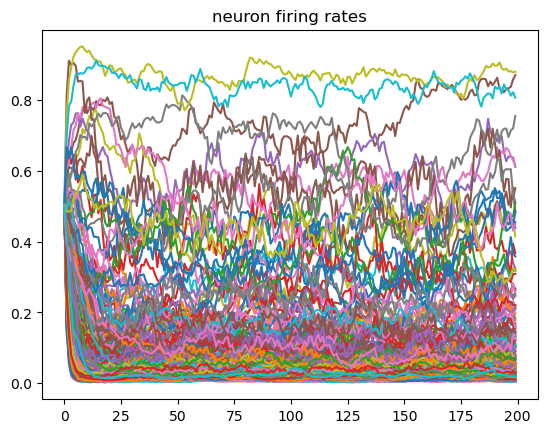

In [16]:
plt.plot(r[:,:,0])
plt.title('neuron firing rates')
plt.show()

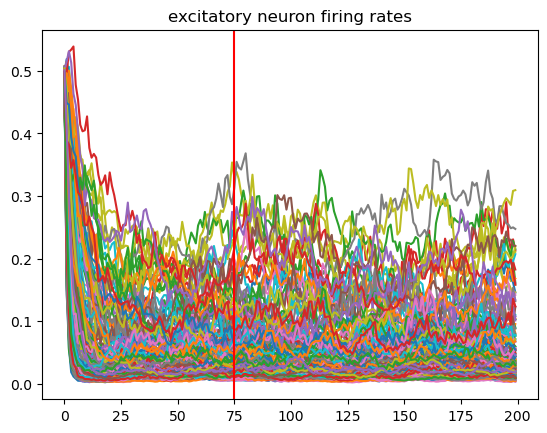

In [17]:
plt.plot(r[:,exc_ind,0])
plt.axvline(resp_onset,c='r')
plt.title('excitatory neuron firing rates')
plt.show()

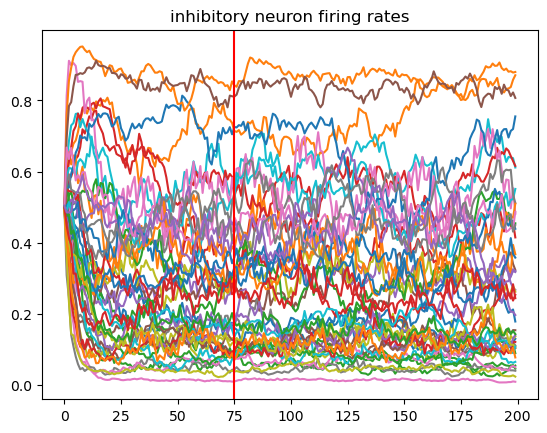

In [18]:
plt.plot(r[:,inh_ind,0])
plt.axvline(resp_onset,c='r')
plt.title('inhibitory neuron firing rates')
plt.show()

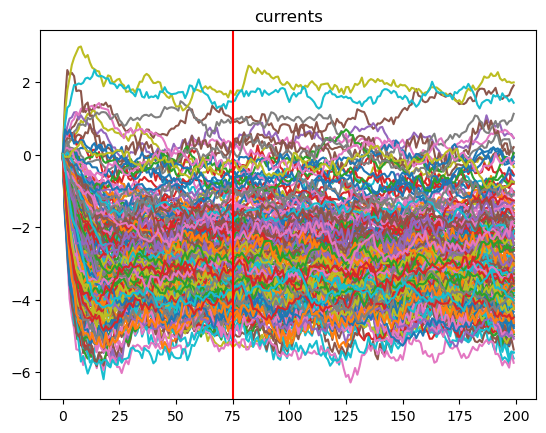

In [19]:
plt.plot(x[:,:,0])
plt.axvline(75,c='r')
plt.title('currents')
plt.show()

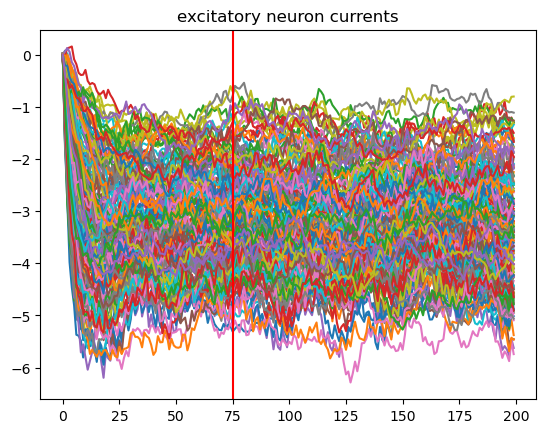

In [20]:
plt.plot(x[:,exc_ind,0])
plt.axvline(resp_onset,c='r')
plt.title('excitatory neuron currents')
plt.show()

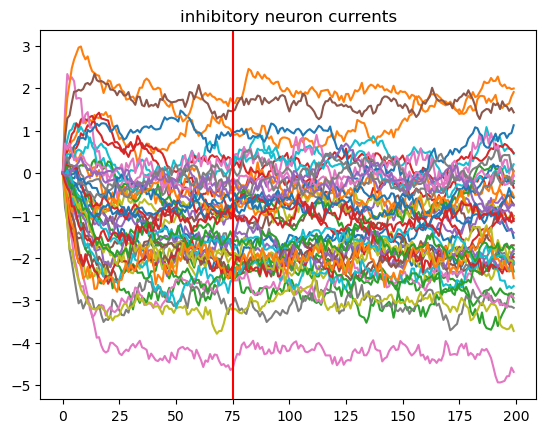

In [21]:
plt.plot(x[:,inh_ind,0])
plt.axvline(resp_onset,c='r')
plt.title('inhibitory neuron currents')
plt.show()

### plotting model outputs r and x from multiple trials

#### trying to get EPSPs from current

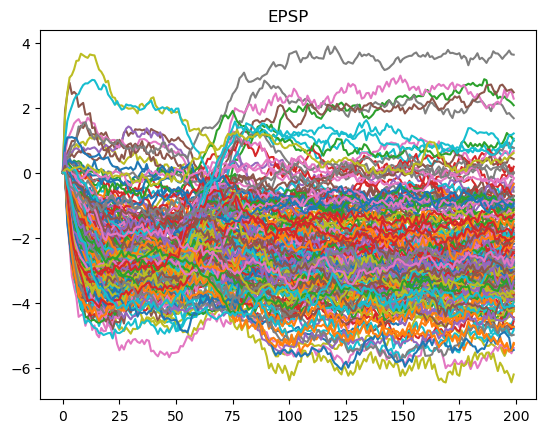

In [22]:
# one trial first
importlib.reload(model)

eval_u, eval_label = generate_input_stim_go_nogo(settings)
x, r, eval_o, epsp = model.eval_tf(model_dir=f'{model_dir}/{model_fname}', settings=settings, u=eval_u)

plt.figure()
plt.plot(epsp.T)
plt.title('EPSP')
plt.show()

Performance: 1.00


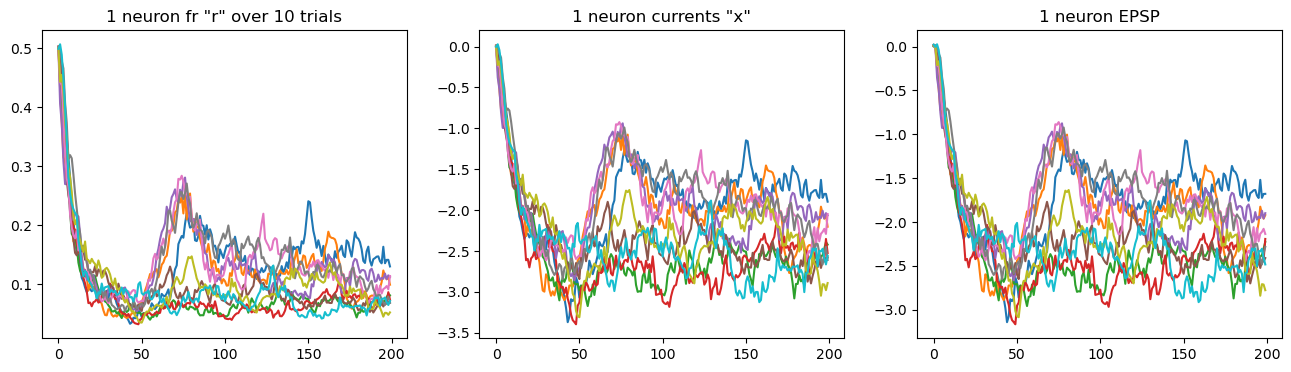

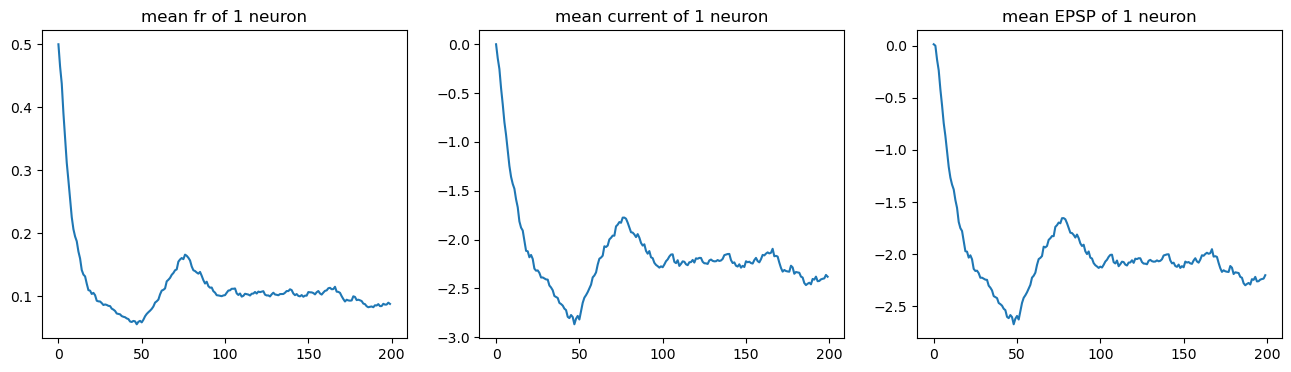

In [23]:
# model eval on 10 random trials

n_trials = 10
n_neurons = 200
resp_onset = settings['stim_on'] + settings['stim_dur']
eval_amp_threshold = 0.7
eval_perf = np.zeros(n_trials)

fig, axs = plt.subplots(1,3,figsize=(16,4))
r_mean = np.zeros((settings['T'], n_neurons))
x_mean = np.zeros((settings['T'], n_neurons))
epsp_mean = np.zeros((settings['T'], n_neurons))
for i in range(n_trials):
    eval_u, eval_label = generate_input_stim_go_nogo(settings)
    x, r, eval_o, epsp = model.eval_tf(model_dir=f'{model_dir}/{model_fname}', settings=settings, u=eval_u)
    if eval_label == 1:
        if np.max(eval_o[resp_onset:]) > eval_amp_threshold:
            eval_perf[i] = 1
    else:
        if np.max(np.abs(eval_o[resp_onset:])) < 0.3:
            eval_perf[i] = 1
    axs[0].plot(r[0,:])
    axs[1].plot(x[0,:])
    axs[2].plot(epsp[0,:])
    r_mean += r
    x_mean += x
    epsp_mean += epsp
r_mean /= n_trials
x_mean /= n_trials 
epsp_mean /= n_trials
axs[0].set_title(f'1 neuron fr "r" over {n_trials} trials')
axs[1].set_title('1 neuron currents "x"')
axs[2].set_title('1 neuron EPSP')

fig, axs = plt.subplots(1,3,figsize=(16,4))
axs[0].plot(r_mean[0,:])
axs[1].plot(x_mean[0,:])
axs[2].plot(epsp_mean[0,:])
axs[0].set_title('mean fr of 1 neuron')
axs[1].set_title('mean current of 1 neuron')
axs[2].set_title('mean EPSP of 1 neuron')

eval_perf_mean = np.nanmean(eval_perf)
print("Performance: %.2f"%(eval_perf_mean))

### Trajectory plots

In [24]:

from sklearn.decomposition import PCA


In [25]:
r = mat_data['r'][:,:,0]
r.shape

(200, 200)

In [26]:
resp_onset = settings['stim_on'] + settings['stim_dur']

X (r): time x neurons  

U: time x n_components  

S: n_components  

Vt: n_components x neurons  

In [27]:
# X = USVt

pca = PCA(n_components=100).fit(r)
r_U = pca.transform(r)
r_S = pca.singular_values_
r_Vt = pca.components_

print(r_U.shape)
print(r_S.shape)
print(r_Vt.shape)

(200, 100)
(100,)
(100, 200)


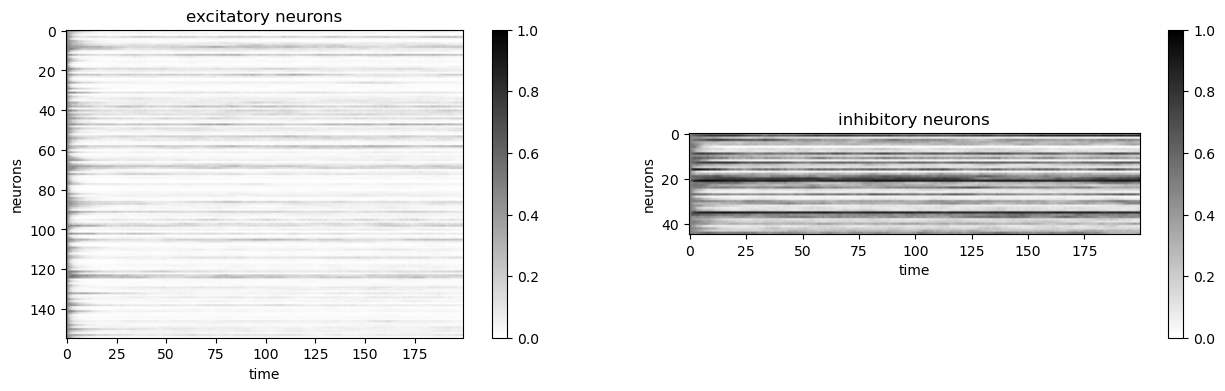

In [28]:
fig,axs = plt.subplots(1,2,figsize=(16,4))
im1 = axs[0].imshow(r[:,exc_ind].T,cmap='binary',vmin=0, vmax=1)
axs[0].set_xlabel('time')
axs[0].set_ylabel('neurons')
axs[0].set_title('excitatory neurons')
fig.colorbar(im1)

im2 = axs[1].imshow(r[:,inh_ind].T,cmap='binary',vmin=0, vmax=1)
axs[1].set_xlabel('time')
axs[1].set_ylabel('neurons')
axs[1].set_title('inhibitory neurons')
fig.colorbar(im2)

plt.show()

In [29]:
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline 
# %matplotlib widget

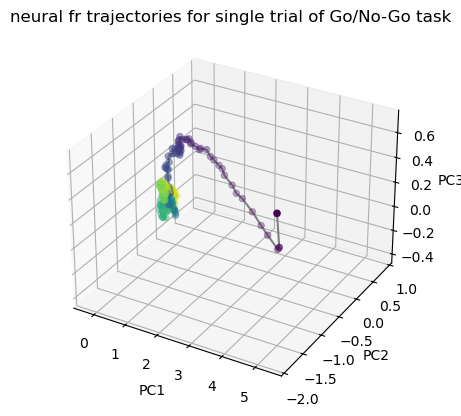

In [30]:
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(r_U[:,0], r_U[:,1], r_U[:,2], c=range(200))
ax.plot3D(r_U[:,0], r_U[:,1], r_U[:,2], 'gray')
ax.scatter(r_U[resp_onset,0], r_U[resp_onset,1], r_U[resp_onset,2], c='r')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('neural fr trajectories for single trial of Go/No-Go task')
plt.show()

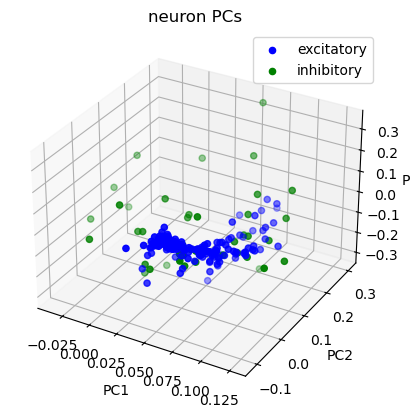

In [31]:
# neuron PCs 1, 2, 3
ax = plt.figure().add_subplot(projection='3d')
ax.scatter(r_Vt[0,exc_ind],r_Vt[1,exc_ind], r_Vt[2,exc_ind],c='b')
ax.scatter(r_Vt[0,inh_ind],r_Vt[1,inh_ind], r_Vt[2,inh_ind], c='g')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend(['excitatory','inhibitory'])
ax.set_title('neuron PCs')
plt.show()

#### plot separate trajectories for excitatory vs inhibitory

In [32]:
# X = USVt

# excitatory
pca_exc = PCA(n_components=10).fit(r[:,exc_ind])
r_U_exc = pca_exc.transform(r[:,exc_ind])
print(r_U_exc.shape)

# inhibitory
pca_inh = PCA(n_components=10).fit(r[:,inh_ind])
r_U_inh = pca_inh.transform(r[:,inh_ind])
print(r_U_inh.shape)

(200, 10)
(200, 10)


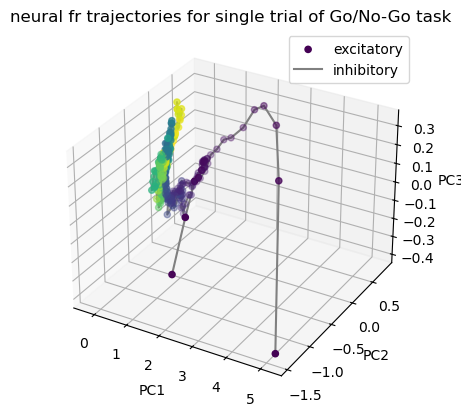

In [33]:
ax = plt.figure().add_subplot(projection='3d')

ax.scatter(r_U_exc[:,0], r_U_exc[:,1], r_U_exc[:,2], c=range(200))
ax.plot3D(r_U_exc[:,0], r_U_exc[:,1], r_U_exc[:,2], 'gray')
ax.scatter(r_U_exc[resp_onset,0], r_U_exc[resp_onset,1], r_U_exc[resp_onset,2], c='r')

ax.scatter(r_U_inh[:,0], r_U_inh[:,1], r_U_inh[:,2], c=range(200))
ax.plot3D(r_U_inh[:,0], r_U_inh[:,1], r_U_inh[:,2], 'gray')
ax.scatter(r_U_inh[resp_onset,0], r_U_inh[resp_onset,1], r_U_inh[resp_onset,2], c='r')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('neural fr trajectories for single trial of Go/No-Go task')
ax.legend(['excitatory','inhibitory'])
plt.show()

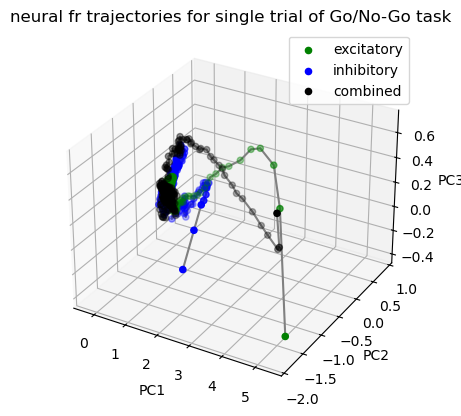

In [34]:
ax = plt.figure().add_subplot(projection='3d')

# plot trajectories
ax.scatter(r_U_exc[:,0], r_U_exc[:,1], r_U_exc[:,2],c='g') 
ax.scatter(r_U_inh[:,0], r_U_inh[:,1], r_U_inh[:,2], c='b')
ax.scatter(r_U[:,0], r_U[:,1], r_U[:,2],c='k')

ax.plot3D(r_U_exc[:,0], r_U_exc[:,1], r_U_exc[:,2], 'gray')
ax.plot3D(r_U_inh[:,0], r_U_inh[:,1], r_U_inh[:,2], 'gray')
ax.plot3D(r_U[:,0], r_U[:,1], r_U[:,2], 'gray')

ax.scatter(r_U_exc[resp_onset,0], r_U_exc[resp_onset,1], r_U_exc[resp_onset,2], c='r')
ax.scatter(r_U_inh[resp_onset,0], r_U_inh[resp_onset,1], r_U_inh[resp_onset,2], c='r')
ax.scatter(r_U[resp_onset,0], r_U[resp_onset,1], r_U[resp_onset,2], c='r')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('neural fr trajectories for single trial of Go/No-Go task')
ax.legend(['excitatory','inhibitory','combined'])
plt.show()

#### plot separate trajectories for multiple trials (colored by go / no-go)

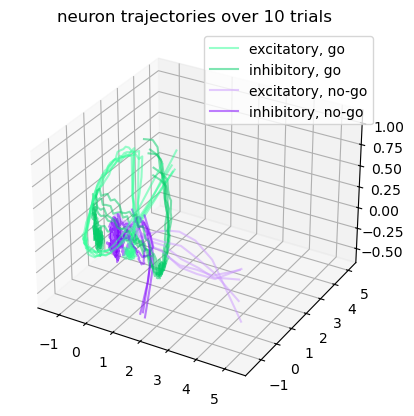

Performance: 1.00


In [35]:
# model eval on 10 random trials

n_trials = 10
n_neurons = 200
resp_onset = settings['stim_on'] + settings['stim_dur']
eval_amp_threshold = 0.7
eval_perf = np.zeros(n_trials)

ax = plt.figure().add_subplot(projection='3d')
for i in range(n_trials):
    # generate trial
    u, label = generate_input_stim_go_nogo(settings)
    x, r, o, epsp = model.eval_tf(model_dir=f'{model_dir}/{model_fname}', settings=settings, u=u)
    r = r.T
    
    # do PCA
    U_pcs_exc = PCA(n_components=10).fit(r[:,exc_ind]).transform(r[:,exc_ind])
    U_pcs_inh = PCA(n_components=10).fit(r[:,inh_ind]).transform(r[:,inh_ind])
    
    if label == 1: # go
        line1, = ax.plot3D(U_pcs_exc[:,0], U_pcs_exc[:,1], U_pcs_exc[:,2], color='#33FF99', alpha=0.5) # excitatory
        # ax.scatter(U_pcs_exc[:,0], U_pcs_exc[:,1], U_pcs_exc[:,2], c=(51,255,153))
        # ax.scatter(U_pcs_exc[resp_onset,0], U_pcs_exc[resp_onset,1], U_pcs_exc[resp_onset,2], c='r')

        line2, = ax.plot3D(U_pcs_inh[:,0], U_pcs_inh[:,1], U_pcs_inh[:,2], color='#00CC66', alpha=0.5) # inhibitory

        if np.max(o[resp_onset:]) > eval_amp_threshold:
            eval_perf[i] = 1

    else: # no-go
        line3, = ax.plot3D(U_pcs_exc[:,0], U_pcs_exc[:,1], U_pcs_exc[:,2], color='#CC99FF', alpha=0.5) # excitatory
        # ax.scatter(U_pcs_exc[:,0], U_pcs_exc[:,1], U_pcs_exc[:,2], c=(0,204,102))
        # ax.scatter(U_pcs_exc[resp_onset,0], U_pcs_exc[resp_onset,1], U_pcs_exc[resp_onset,2], c='r')
        line4, = ax.plot3D(U_pcs_inh[:,0], U_pcs_inh[:,1], U_pcs_inh[:,2], color='#7F00FF', alpha=0.5) # inhibitory

        if np.max(np.abs(o[resp_onset:])) < 0.3:
            eval_perf[i] = 1


ax.set_title(f'neuron trajectories over {n_trials} trials')
plt.legend([line1, line2, line3, line4], ['excitatory, go','inhibitory, go', 'excitatory, no-go','inhibitory, no-go'])
plt.show()

eval_perf_mean = np.nanmean(eval_perf)
print("Performance: %.2f"%(eval_perf_mean))

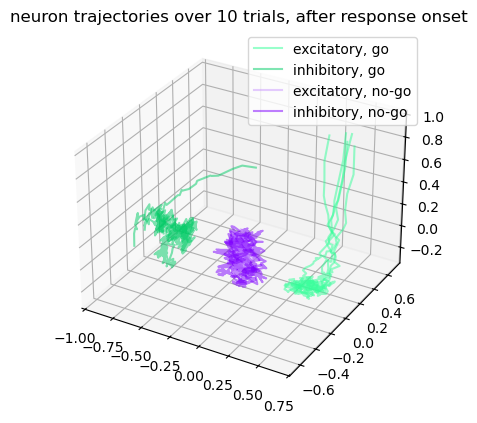

Performance: 1.00


In [37]:
# model eval on 10 random trials, plotting only after response onset

n_trials = 10
n_neurons = 200
resp_onset = settings['stim_on'] + settings['stim_dur']
eval_amp_threshold = 0.7
eval_perf = np.zeros(n_trials)

ax = plt.figure().add_subplot(projection='3d')
for i in range(n_trials):
    # generate trial
    u, label = generate_input_stim_go_nogo(settings)
    x, r, o, _ = model.eval_tf(model_dir=f'{model_dir}/{model_fname}', settings=settings, u=u)
    r = r.T
    
    # do PCA
    U_pcs_exc = PCA(n_components=10).fit(r[:,exc_ind]).transform(r[:,exc_ind])
    U_pcs_inh = PCA(n_components=10).fit(r[:,inh_ind]).transform(r[:,inh_ind])
    
    if label == 1: # go
        line1, = ax.plot3D(U_pcs_exc[resp_onset:,0], U_pcs_exc[resp_onset:,1], U_pcs_exc[resp_onset:,2], color='#33FF99', alpha=0.5) # excitatory
        # ax.scatter(U_pcs_exc[:,0], U_pcs_exc[:,1], U_pcs_exc[:,2], c=(51,255,153))
        # ax.scatter(U_pcs_exc[resp_onset,0], U_pcs_exc[resp_onset,1], U_pcs_exc[resp_onset,2], c='r')

        line2, = ax.plot3D(U_pcs_inh[resp_onset:,0], U_pcs_inh[resp_onset:,1], U_pcs_inh[resp_onset:,2], color='#00CC66', alpha=0.5) # inhibitory

        if np.max(o[resp_onset:]) > eval_amp_threshold:
            eval_perf[i] = 1

    else: # no-go
        line3, = ax.plot3D(U_pcs_exc[resp_onset:,0], U_pcs_exc[resp_onset:,1], U_pcs_exc[resp_onset:,2], color='#CC99FF', alpha=0.5) # excitatory
        # ax.scatter(U_pcs_exc[:,0], U_pcs_exc[:,1], U_pcs_exc[:,2], c=(0,204,102))
        # ax.scatter(U_pcs_exc[resp_onset,0], U_pcs_exc[resp_onset,1], U_pcs_exc[resp_onset,2], c='r')
        line4, = ax.plot3D(U_pcs_inh[resp_onset:,0], U_pcs_inh[resp_onset:,1], U_pcs_inh[resp_onset:,2], color='#7F00FF', alpha=0.5) # inhibitory

        if np.max(np.abs(o[resp_onset:])) < 0.3:
            eval_perf[i] = 1


ax.set_title(f'neuron trajectories over {n_trials} trials, after response onset')
plt.legend([line1, line2, line3, line4], ['excitatory, go','inhibitory, go', 'excitatory, no-go','inhibitory, no-go'])
plt.show()

eval_perf_mean = np.nanmean(eval_perf)
print("Performance: %.2f"%(eval_perf_mean))

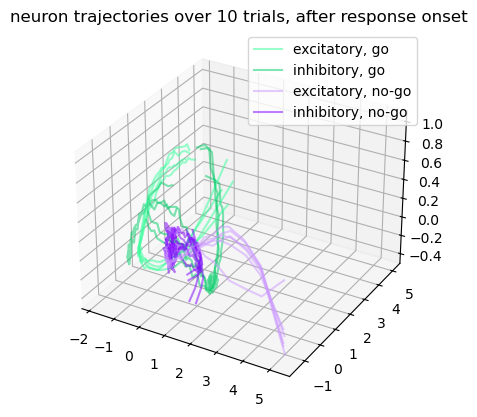

Performance: 1.00


In [39]:
# model eval on 10 random trials, plotting only before response onset

n_trials = 10
n_neurons = 200
resp_onset = settings['stim_on'] + settings['stim_dur']
eval_amp_threshold = 0.7
eval_perf = np.zeros(n_trials)

ax = plt.figure().add_subplot(projection='3d')
for i in range(n_trials):
    # generate trial
    u, label = generate_input_stim_go_nogo(settings)
    x, r, o, _ = model.eval_tf(model_dir=f'{model_dir}/{model_fname}', settings=settings, u=u)
    r = r.T
    
    # do PCA
    U_pcs_exc = PCA(n_components=10).fit(r[:,exc_ind]).transform(r[:,exc_ind])
    U_pcs_inh = PCA(n_components=10).fit(r[:,inh_ind]).transform(r[:,inh_ind])
    
    if label == 1: # go
        line1, = ax.plot3D(U_pcs_exc[:resp_onset,0], U_pcs_exc[:resp_onset,1], U_pcs_exc[:resp_onset,2], color='#33FF99', alpha=0.5) # excitatory
        line2, = ax.plot3D(U_pcs_inh[:resp_onset,0], U_pcs_inh[:resp_onset,1], U_pcs_inh[:resp_onset,2], color='#00CC66', alpha=0.5) # inhibitory

        if np.max(o[resp_onset:]) > eval_amp_threshold:
            eval_perf[i] = 1

    else: # no-go
        line3, = ax.plot3D(U_pcs_exc[:resp_onset,0], U_pcs_exc[:resp_onset,1], U_pcs_exc[:resp_onset,2], color='#CC99FF', alpha=0.5) # excitatory
        line4, = ax.plot3D(U_pcs_inh[:resp_onset,0], U_pcs_inh[:resp_onset,1], U_pcs_inh[:resp_onset,2], color='#7F00FF', alpha=0.5) # inhibitory

        if np.max(np.abs(o[resp_onset:])) < 0.3:
            eval_perf[i] = 1


ax.set_title(f'neuron trajectories over {n_trials} trials, after response onset')
plt.legend([line1, line2, line3, line4], ['excitatory, go','inhibitory, go', 'excitatory, no-go','inhibitory, no-go'])
plt.show()

eval_perf_mean = np.nanmean(eval_perf)
print("Performance: %.2f"%(eval_perf_mean))

##### phate

giving up bc installation / M2 chip issues blehhhhh

##### synaptic decay constants

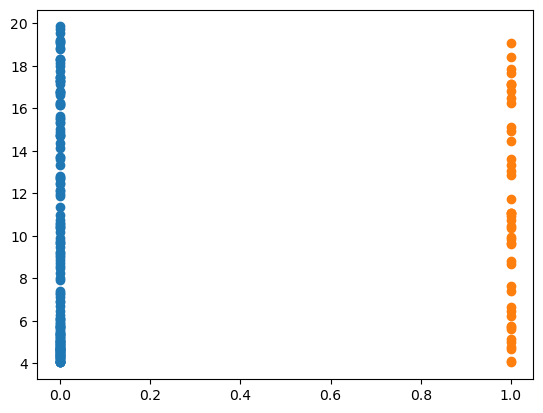

In [40]:
plt.scatter(np.zeros(len(exc_ind)),taus_sig[exc_ind])
plt.scatter(np.ones(len(inh_ind)),taus_sig[inh_ind])
plt.show()

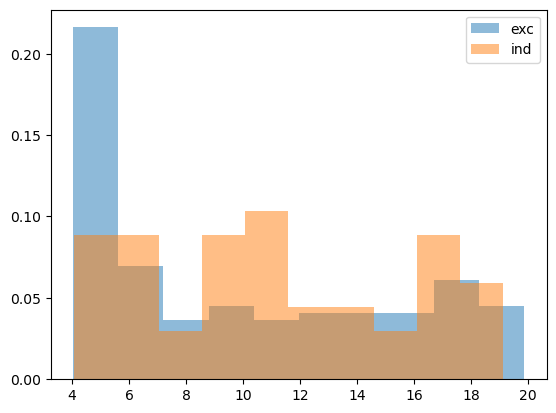

In [41]:
plt.hist(taus_sig[exc_ind], density=True, alpha=0.5)
plt.hist(taus_sig[inh_ind], density=True, alpha=0.5)
plt.legend(['exc','ind'])
plt.show()

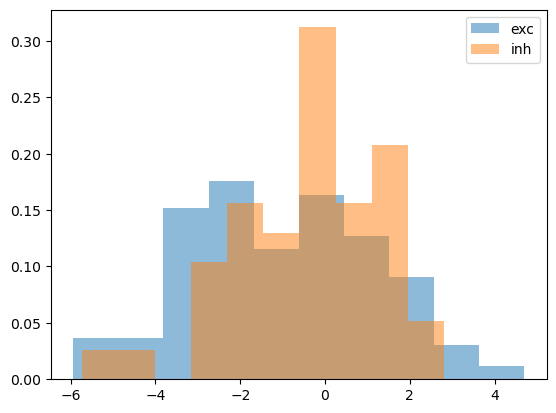

In [42]:
plt.hist(mat_data['taus_gaus'][exc_ind], density=True, alpha=0.5)
plt.hist(mat_data['taus_gaus'][inh_ind], density=True, alpha=0.5)
plt.legend(['exc','inh'])
plt.show()

### Spectrograms for LFPs

#### Raw signal

In [43]:
from scipy.signal import spectrogram

(200, 200)


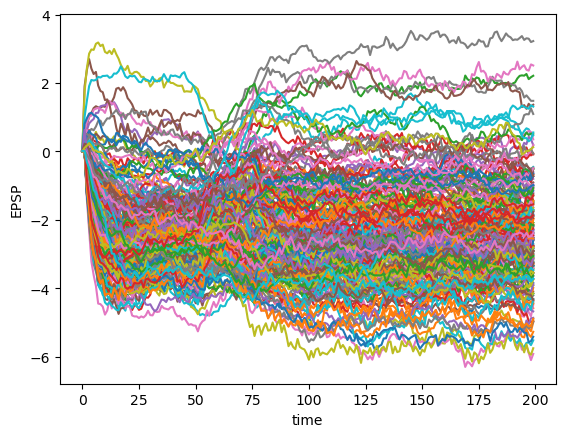

In [44]:
plt.plot(epsp.T)#, cmap='binary')
print(epsp.shape)
plt.xlabel('time')
plt.ylabel('EPSP')
plt.show()

(13,)
(8,)
(200, 13, 8)
[0.0625 0.1725 0.2825 0.3925 0.5025 0.6125 0.7225 0.8325]
[ 0.  8. 16. 24. 32. 40. 48. 56. 64. 72. 80. 88. 96.]


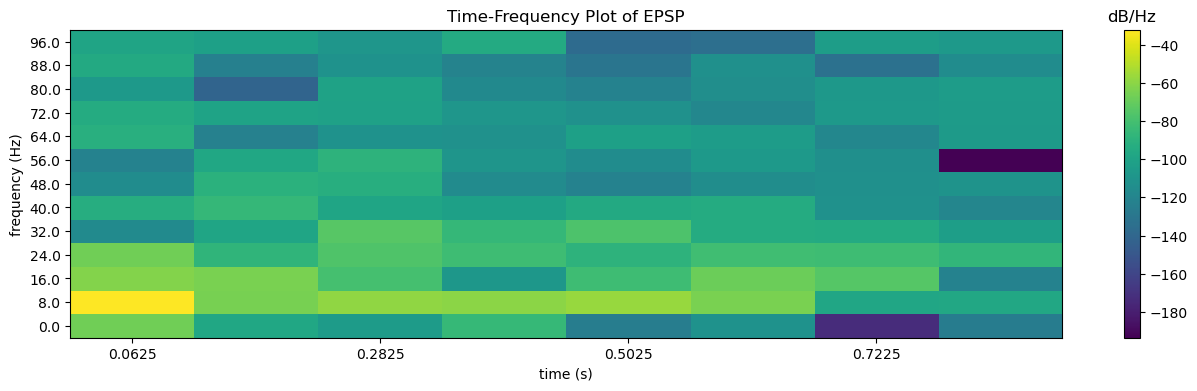

In [45]:
f, t, s = spectrogram(epsp, fs=200, window=('tukey', 0.25), scaling='density', nperseg=25)
# s = s[:,:,0]
print(f.shape)
print(t.shape)
print(s.shape)

print(t)
print(f)

plt.figure(figsize=(16,4))
plt.imshow(10*np.log(s[0,:,:]), aspect='auto', origin='lower')
plt.xlabel('time (s)')
# plt.xticks(range(len(f)),t[::(int((len(t)/len(f))+1))])
# plt.xticks(range(len(t)),t.astype(int))
plt.xticks(range(len(t))[::2],t[::2])
plt.ylabel('frequency (Hz)')
plt.yticks(range(len(f)),f)
cbar = plt.colorbar()
# cbar.ax.set_ylabel('dB/Hz', rotation=270)
cbar.ax.set_title('dB/Hz')
plt.title('Time-Frequency Plot of EPSP')
plt.show()


##### plotting with almost no overlap:

(51,)
(151,)
(200, 51, 151)


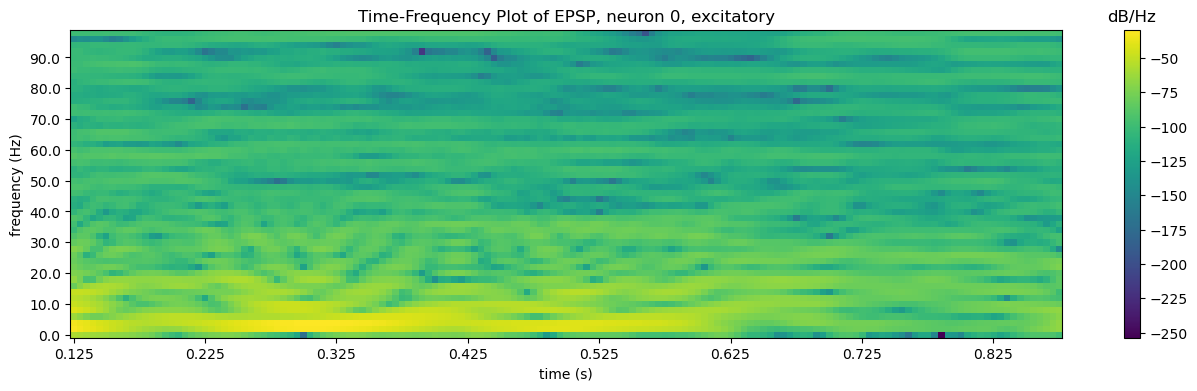

In [47]:
nperseg=50
fs = 200
f, t, s = spectrogram(epsp, fs=fs, window=('tukey', 0.25), scaling='density', nperseg=nperseg, noverlap=nperseg-1, nfft=nperseg*2)
# s = s[:,:,0]
print(f.shape)
print(t.shape)
print(s.shape)

type_label = ['excitatory','inhibitory']
neuron_num = 0

f_cutoff = 160
f_cutoff_idx = np.where(f <= f_cutoff)[0][-1]

plt.figure(figsize=(16,4))
plt.imshow(10*np.log(s[neuron_num,:f_cutoff_idx,:]), aspect='auto', origin='lower')
plt.xlabel('time (s)')
plt.xticks(range(len(t))[::20],t[::20])
plt.ylabel('frequency (Hz)')
plt.yticks(range(len(f[:f_cutoff_idx]))[::5],f[:f_cutoff_idx][::5])
cbar = plt.colorbar()
cbar.ax.set_title('dB/Hz')
plt.title(f'Time-Frequency Plot of EPSP, neuron {neuron_num}, {type_label[inh[neuron_num][0]]}')
plt.show()


beta signal:

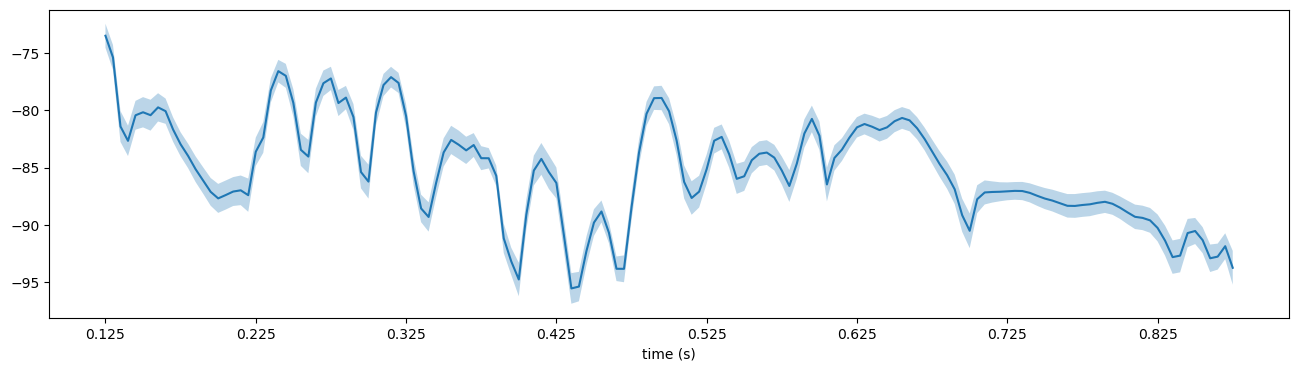

In [49]:
# plotting beta power (approx 15-30Hz)
f_beta_idx = np.where((f >= 13) & (f <=30))[0]
beta_power = 10*np.log(s[neuron_num,f_beta_idx,:])
beta_mean = np.nanmean(beta_power, axis=0)
beta_std = np.nanstd(beta_power, axis=0)
beta_sem = np.sqrt(beta_std)/np.sqrt(beta_power.shape[0])

plt.figure(figsize=(16,4))
plt.plot(beta_mean)
plt.fill_between(range(len(beta_mean)), beta_mean - beta_sem, beta_mean + beta_sem, alpha=0.3)
plt.xlabel('time (s)')
plt.xticks(range(len(t))[::20],t[::20])
plt.show()

#### upsampling

In [50]:
def upsample(signal, fs, upsample_fs):
    # signal is (neurons x time)

    down_time = np.linspace(0, 1, fs)
    up_time = np.linspace(0, 1, upsample_fs)

    n_neurons = signal.shape[0]
    up_signal = np.zeros((n_neurons,len(up_time)))
    for i in range(n_neurons):
        intp1 = scipy.interpolate.interp1d(down_time, signal[i,:], kind='linear')
        up_signal[i,:] = intp1(up_time)

    return up_signal

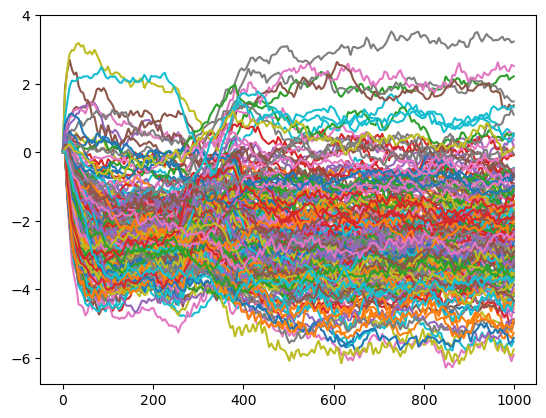

In [51]:
fs = 200
upsample_fs = 1000

up_epsp = upsample(epsp, fs=fs, upsample_fs=upsample_fs)
plt.plot(up_epsp.T)
plt.show()

(26,)
(22,)
(200, 26, 22)
500.0
0.949


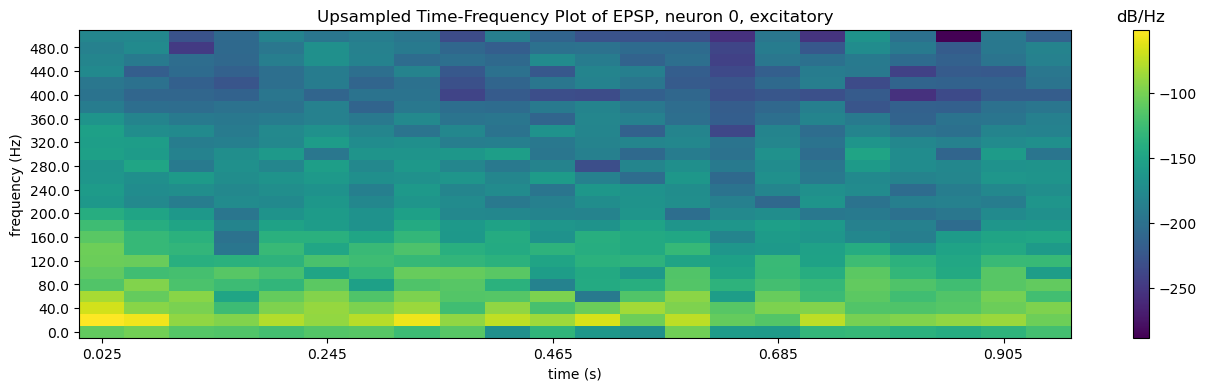

In [52]:
f, t, s = spectrogram(up_epsp, fs=upsample_fs, window=('tukey', 0.25), scaling='density', nperseg=50)
# s = s[:,:,0]
print(f.shape)
print(t.shape)
print(s.shape)

print(max(f))
print(max(t))

type_label = ['excitatory','inhibitory']
neuron_num = 0

plt.figure(figsize=(16,4))
plt.imshow(10*np.log(s[neuron_num,:,:]), aspect='auto', origin='lower')
plt.xlabel('time (s)')
plt.xticks(range(len(t))[::5],t[::5])
plt.ylabel('frequency (Hz)')
plt.yticks(range(len(f))[::2],f[::2])
cbar = plt.colorbar()
cbar.ax.set_title('dB/Hz')
plt.title(f'Upsampled Time-Frequency Plot of EPSP, neuron {neuron_num}, {type_label[inh[neuron_num][0]]}')
plt.show()

##### Finer frequency resolution

(101,)
(27,)
(200, 101, 27)


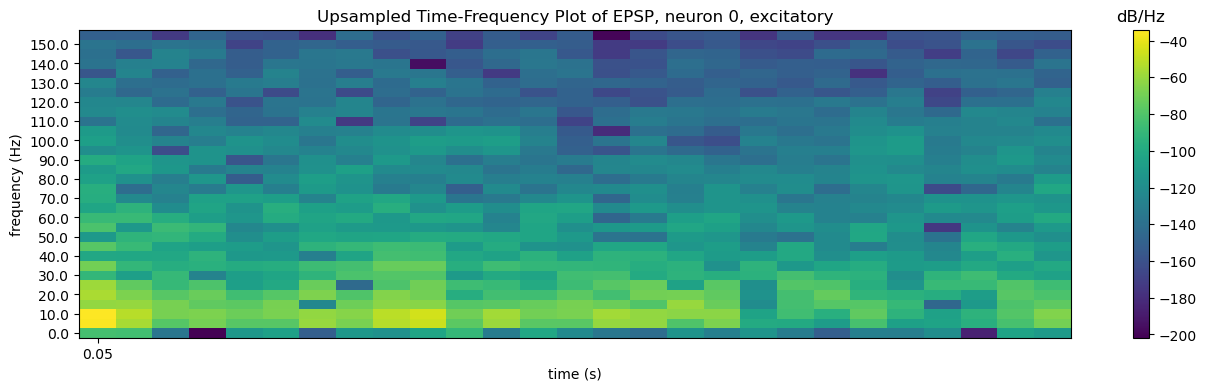

In [53]:
nperseg=100
f, t, s = spectrogram(up_epsp, fs=upsample_fs, window=('tukey', 0.25), scaling='density', nperseg=nperseg, noverlap=nperseg//1.5, nfft=nperseg*2)
# s = s[:,:,0]
print(f.shape)
print(t.shape)
print(s.shape)

type_label = ['excitatory','inhibitory']
neuron_num = 0

f_cutoff = 160
f_cutoff_idx = np.where(f <= f_cutoff)[0][-1]

plt.figure(figsize=(16,4))
plt.imshow(10*np.log(s[neuron_num,:f_cutoff_idx,:]), aspect='auto', origin='lower')
plt.xlabel('time (s)')
plt.xticks(range(len(t))[::50],t[::50])
plt.ylabel('frequency (Hz)')
plt.yticks(range(len(f[:f_cutoff_idx]))[::2],f[:f_cutoff_idx][::2])
cbar = plt.colorbar()
cbar.ax.set_title('dB/Hz')
plt.title(f'Upsampled Time-Frequency Plot of EPSP, neuron {neuron_num}, {type_label[inh[neuron_num][0]]}')
plt.show()

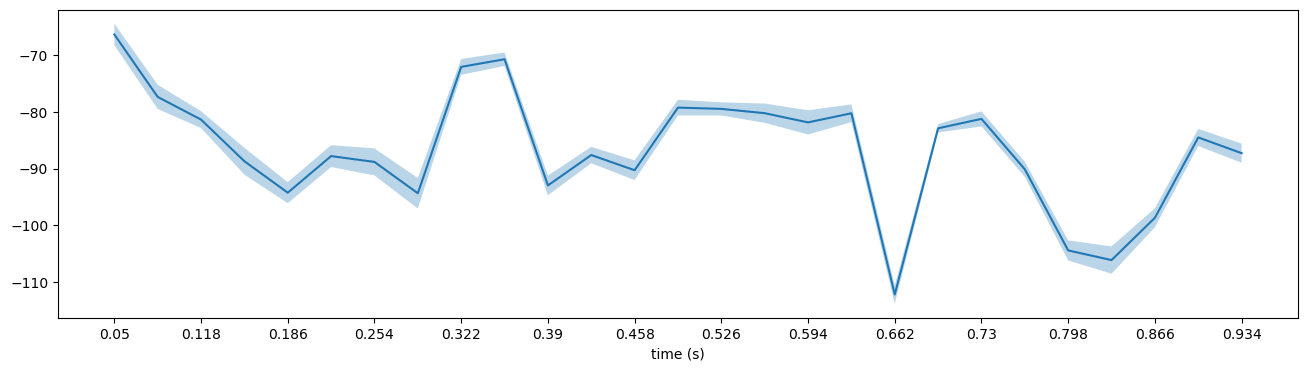

In [54]:
# plotting beta power (approx 15-30Hz)
f_beta_idx = np.where((f >= 13) & (f <=30))[0]
beta_power = 10*np.log(s[neuron_num,f_beta_idx,:])
beta_mean = np.nanmean(beta_power, axis=0)
beta_std = np.nanstd(beta_power, axis=0)
beta_sem = np.sqrt(beta_std)/np.sqrt(beta_power.shape[0])

plt.figure(figsize=(16,4))
plt.plot(beta_mean)
plt.fill_between(range(len(beta_mean)), beta_mean - beta_sem, beta_mean + beta_sem, alpha=0.3)
plt.xlabel('time (s)')
plt.xticks(range(len(t))[::2],t[::2])
plt.show()

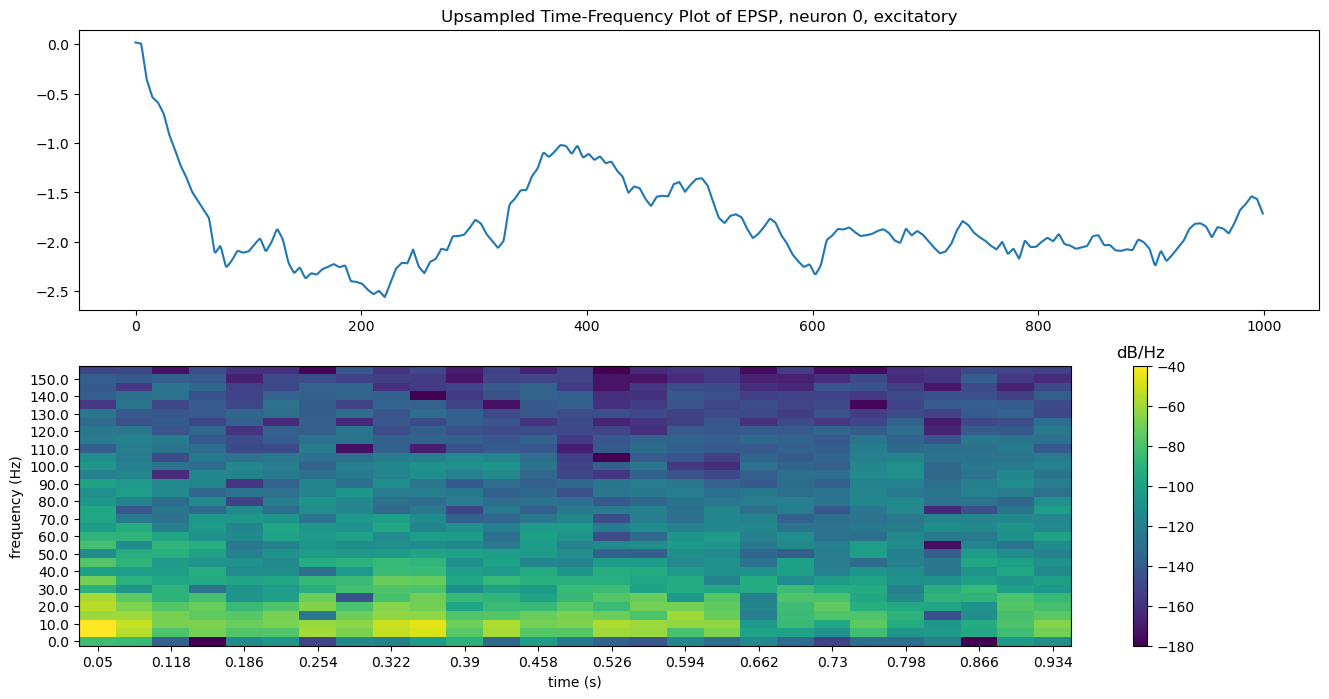

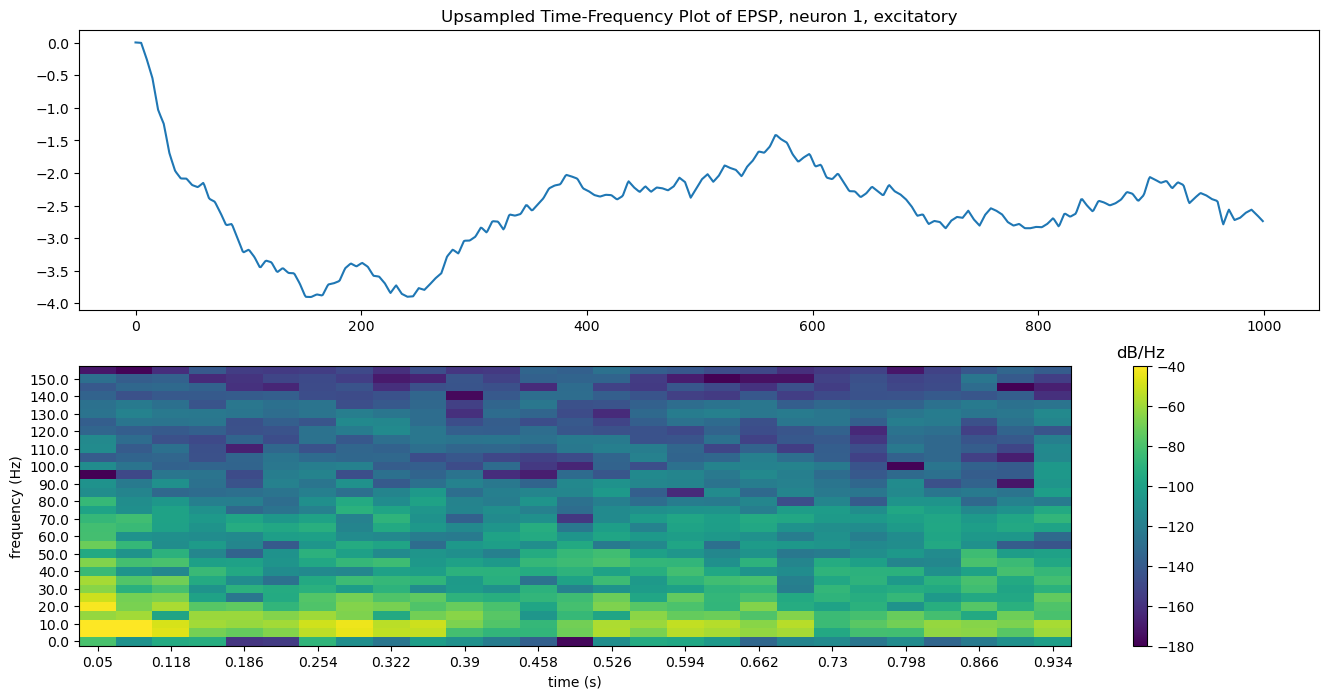

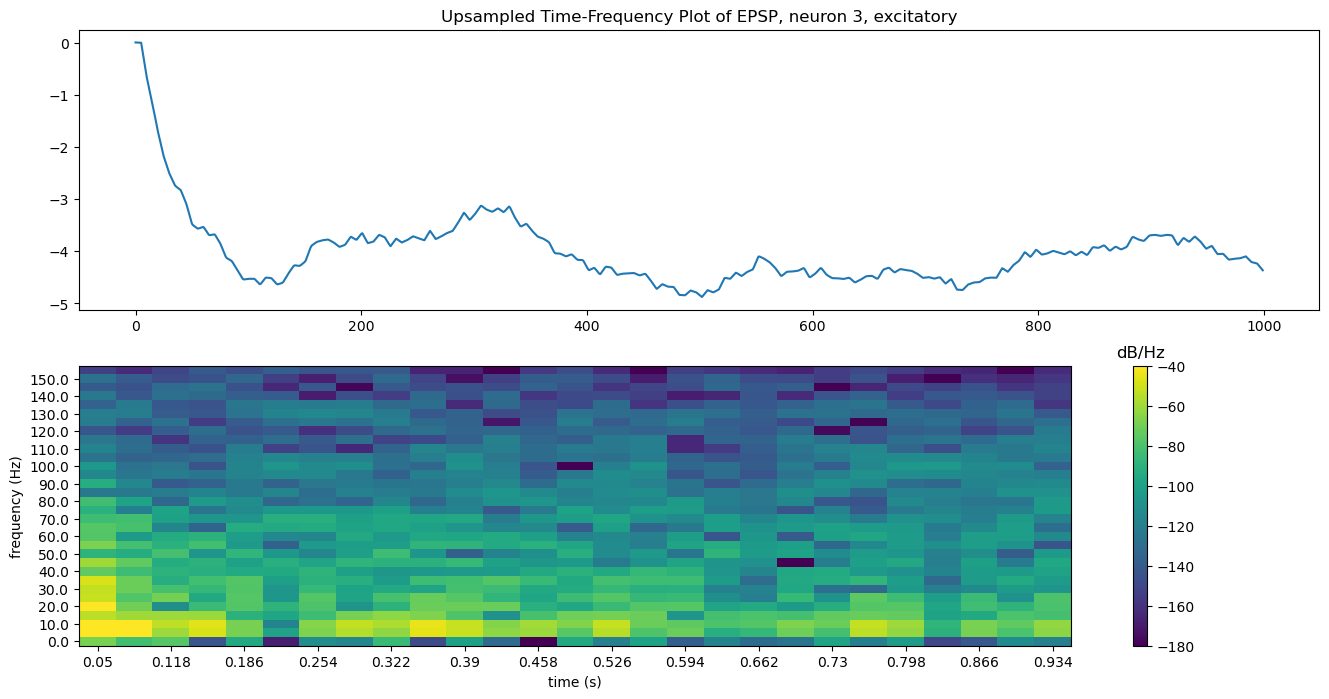

In [55]:
# plotting some excitatory
type_label = ['excitatory','inhibitory']

f_cutoff = 160
f_cutoff_idx = np.where(f <= f_cutoff)[0][-1]

for neuron_num in exc_ind[:3]:

    fig, axs = plt.subplots(2,1,figsize=(16,8))
    im1 = axs[0].plot(up_epsp[neuron_num,:])

    im = axs[1].imshow(10*np.log(s[neuron_num,:f_cutoff_idx,:]), aspect='auto', origin='lower', vmin=-180, vmax=-40)
    axs[1].set_xlabel('time (s)')
    axs[1].set_xticks(range(len(t))[::2],t[::2])
    axs[1].set_ylabel('frequency (Hz)')
    axs[1].set_yticks(range(len(f[:f_cutoff_idx]))[::2],f[:f_cutoff_idx][::2])
    cbar = fig.colorbar(im)
    cbar.ax.set_title('dB/Hz')

    axs[0].set_title(f'Upsampled Time-Frequency Plot of EPSP, neuron {neuron_num}, {type_label[inh[neuron_num][0]]}')
    plt.show()

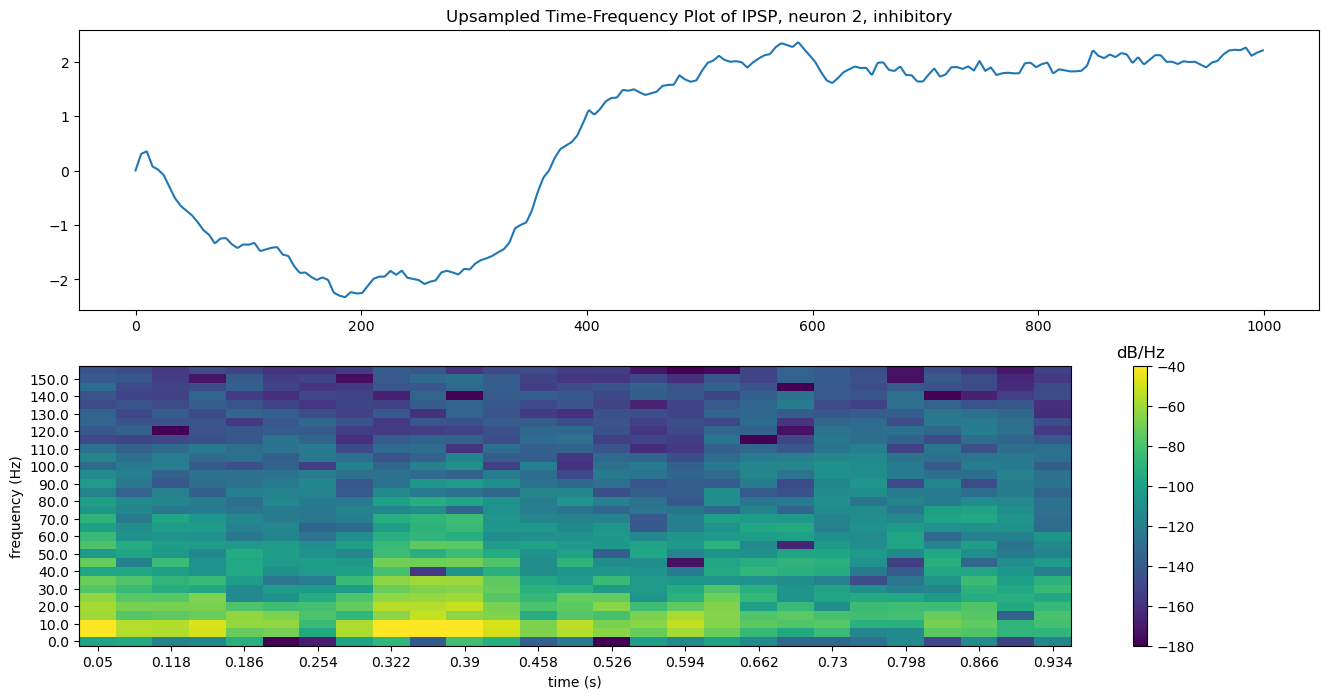

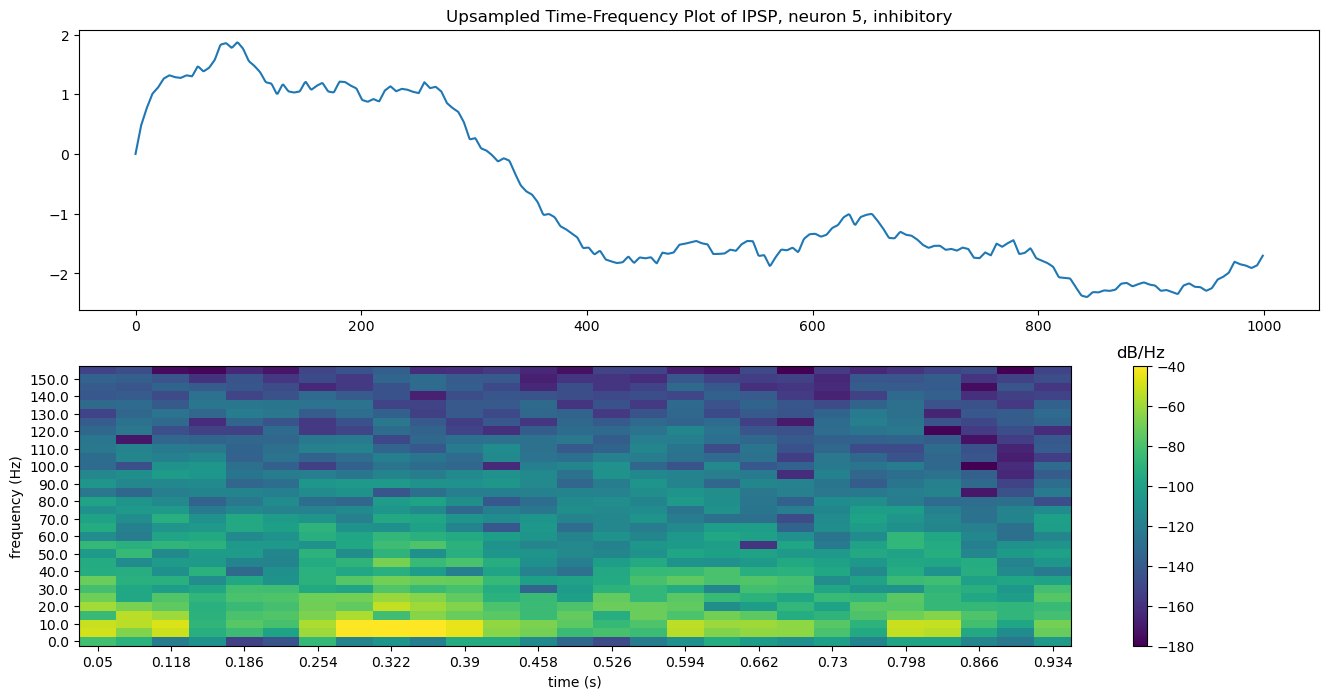

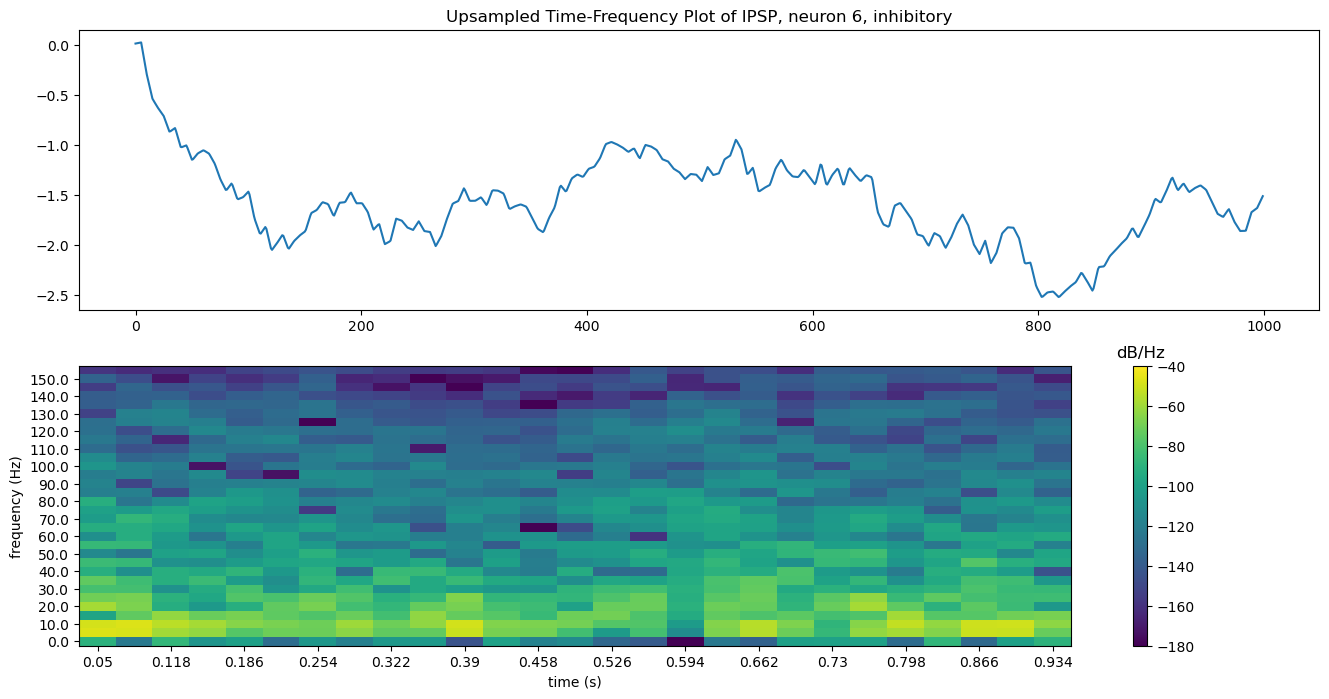

In [56]:
# plotting some inhibitory
type_label = ['excitatory','inhibitory']

f_cutoff = 160
f_cutoff_idx = np.where(f <= f_cutoff)[0][-1]

for neuron_num in inh_ind[:3]:

    fig, axs = plt.subplots(2,1,figsize=(16,8))
    im1 = axs[0].plot(up_epsp[neuron_num,:])

    im = axs[1].imshow(10*np.log(s[neuron_num,:f_cutoff_idx,:]), aspect='auto', origin='lower', vmin=-180, vmax=-40)
    axs[1].set_xlabel('time (s)')
    axs[1].set_xticks(range(len(t))[::2],t[::2])
    axs[1].set_ylabel('frequency (Hz)')
    axs[1].set_yticks(range(len(f[:f_cutoff_idx]))[::2],f[:f_cutoff_idx][::2])
    cbar = fig.colorbar(im)
    cbar.ax.set_title('dB/Hz')

    axs[0].set_title(f'Upsampled Time-Frequency Plot of IPSP, neuron {neuron_num}, {type_label[inh[neuron_num][0]]}')
    plt.show()

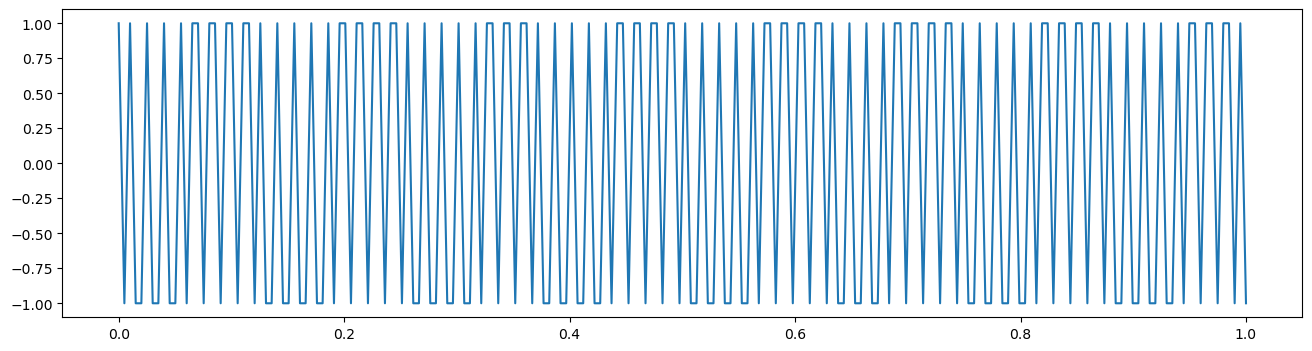

200

In [14]:
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt

t = np.linspace(0,1,200) #sampling rate
plt.figure(figsize=(16,4))
pulse = scipy.signal.square(2*np.pi*130*t)
plt.plot(t,pulse) #frequency of wave
plt.show()
len(t)

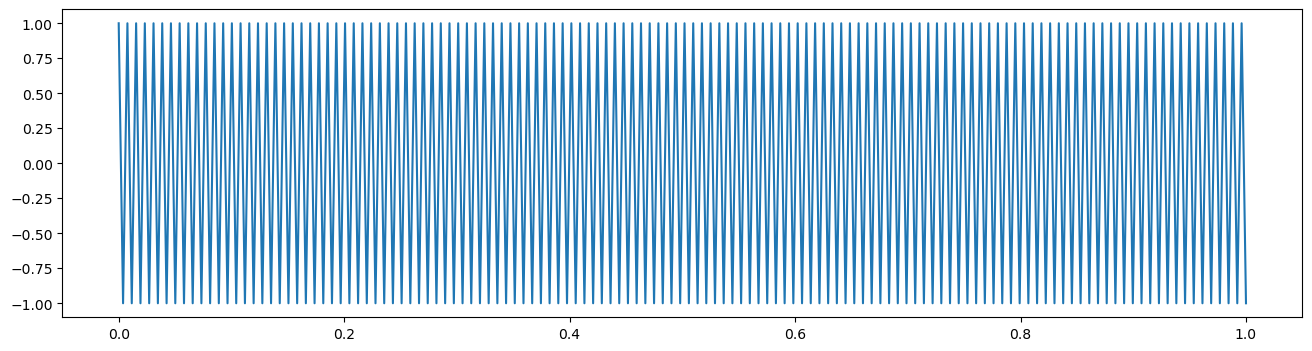

In [12]:
t = np.linspace(0,1,260) #sampling rate
plt.figure(figsize=(16,4))
plt.plot(t,scipy.signal.square(2*np.pi*130*t)) #frequency of wave
plt.show()